In [ ]:
#@title
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from wordcloud import WordCloud
import folium
from folium import plugins
from folium.plugins import HeatMap
import statistics
from collections import Counter
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
#@title
url = "https://drive.google.com/file/d/11yY93yIOI7gHQXpMQXi7IG9cztNzb50Q/view?usp=sharing"
url = "https://drive.google.com/uc?id=" + url.split("/")[-2]
res = pd.read_csv(url)

## Restaurant Ratings Prediction Project - Kelsey Nguyen, Cameron Stivers, Katy Tran

##### CONTEXT OF THE DATA
We have chosen to pick the UberEats dataset because:
- The data is feasible and usable (has a usability score of 10 on Kaggle because of its high quality and well documented datasets) and has potential due to large volumes.
- Since we have gathered the information from the UberEats website, it is authentic and will help us develop practical insights.
- The datasets include multitude of USA restaurants (more than 5k entries) and restaurant menus (more than 400k entries) which enriches the quality of the data.


### 1. Overall Project Objectives
Focusing on restaurants that are partned with UberEats, we are implementing  machine learning strategies to predict restaurant ratings that have not been reviewed.

 - User Perspective: Trending cuisines and quality of restaurants to give customers a better experience
 - UberEat's Perspective: Predict scores of restaurants based on similar restaurants



Some of the questions we are trying to answer are:
 - How many UberEats restaurants are there within each state?
 - What are the most popular/highly rated restaurants?
 - Which restaurant categories (type of cuisine) have the highest ratings?
 - Is there a correlation between number of reviews/ratings and the ratings of a restaurant? In other words, are restaurants with more reviews more highly rated than  restaurants with fewer reviews?




### 2. Description of Data
2 datasets in csv format retreived from the UberEats website: restaurants.csv and restaurant-menus.csv

restaurants.csv (5k entries, 11 columns)

- id (Restaurant id)
- position (Restaurant position in the search result)
- name (Restaurant name)
- score (Restaurant score)
- ratings (Ratings count)
- category (Restaurant category)
- price_range (Restaurant price range

- full_address (Restaurant full address)
- zip_code (Zip code)
- lat (Latitude)
- long (Longitude)


restaurant-menus.csv (400k+ entries, 5 columns)

- restaurant_id (Restaurant id)
- category (Menu category)
- name (Menu Name)
- description (Menu description)
- price (Menu price)

### 3. Data Processing Tasks

#### Generating a cleaned and transformed version of the data:

1. Transfer csv into pandas dataframe
2. Rename "ratings" to "rating_counts" to make it more specific and meaningful (ratings is synonymous with reviews here)
3. Reformat address and split it into County, Neighborhood, State, and Address to make analysis more clear and easy to understand
4. Delete/drop unnecessary columns which could add ambiguity based on logical assumptions
5. Get average menu prices from each restaurant by grouping and match the prices to the corresponding restaurants.
6. Merge average prices from menus dataset to restaurant dataset.





####This is the original dataset before cleaning.

In [ ]:
#@title
url_original = "https://drive.google.com/file/d/1NbQP96fJV5cc7KNCJoF3uuS7PzpeNMnr/view?usp=sharing"
url_original = "https://drive.google.com/uc?id=" + url_original.split("/")[-2]
res_orginal = pd.read_csv(url_original)
res_orginal.head()

,id,position,name,score,ratings,category,price_range,full_address,zip_code,lat,lng
0,1,19,PJ Fresh (224 Daniel Payne Drive),NaN,NaN,"Burgers, American, Sandwiches",$,"224 Daniel Payne Drive, Birmingham, AL, 35207",35207,33.562365,-86.830703
1,2,9,J' ti`'z Smoothie-N-Coffee Bar,NaN,NaN,"Coffee and Tea, Breakfast and Brunch, Bubble Tea",NaN,"1521 Pinson Valley Parkway, Birmingham, AL, 35217",35217,33.583640,-86.773330
2,3,6,Philly Fresh Cheesesteaks (541-B Graymont Ave),NaN,NaN,"American, Cheesesteak, Sandwiches, Alcohol",$,"541-B Graymont Ave, Birmingham, AL, 35204",35204,33.509800,-86.854640
3,4,17,Papa Murphy's (1580 Montgomery Highway),NaN,NaN,Pizza,$,"1580 Montgomery Highway, Hoover, AL, 35226",35226,33.404439,-86.806614
4,5,162,Nelson Brothers Cafe (17th St N),4.7,22.0,"Breakfast and Brunch, Burgers, Sandwiches",NaN,"314 17th St N, Birmingham, AL, 35203",35203,33.514730,-86.811700


####This is the dataset after processing and cleaning.

In [ ]:
#@title
res.head()

,id,name,score,ratings_count,category,County,Address,Neighborhood,State,lat,lng,price
0,1,PJ Fresh (224 Daniel Payne Drive),NaN,NaN,"Burgers, American, Sandwiches",Jefferson Co.,"224 Daniel Payne Dr, Birmingham, AL 35207, Uni...",North Birmingham,AL,33.562365,-86.830703,5.66
1,2,J' ti`'z Smoothie-N-Coffee Bar,NaN,NaN,"Coffee and Tea, Breakfast and Brunch, Bubble Tea",Jefferson Co.,"1521 Pinson Valley Pkwy, Birmingham, AL 35217,...",Birmingham,AL,33.583640,-86.773330,5.51
2,3,Philly Fresh Cheesesteaks (541-B Graymont Ave),NaN,NaN,"American, Cheesesteak, Sandwiches, Alcohol",Jefferson Co.,"1101 Graymont Ave W, Birmingham, AL 35204, Uni...",Five Points West,AL,33.509800,-86.854640,10.76
3,4,Papa Murphy's (1580 Montgomery Highway),NaN,NaN,Pizza,Jefferson Co.,"1580 Montgomery Hwy, Hoover, AL 35226, United ...",Hoover,AL,33.404439,-86.806614,10.53
4,5,Nelson Brothers Cafe (17th St N),4.7,22.0,"Breakfast and Brunch, Burgers, Sandwiches",Jefferson Co.,"314 17th St N, Birmingham, AL 35203, United St...",Northside,AL,33.514730,-86.811700,4.53


### 4. Data Exploration

In [ ]:
#@title
res.describe()

,id,score,ratings_count,lat,lng,price
count,5000.000000,2169.000000,2169.000000,5000.000000,5000.000000,4996.000000
mean,2500.500000,4.486860,52.863071,41.116198,-89.296382,9.440737
std,1443.520003,0.319114,42.944594,4.433820,5.388335,5.572640
min,1.000000,3.000000,10.000000,0.000000,-110.990240,0.000000
25%,1250.750000,4.300000,21.000000,41.786997,-89.301703,6.320000
50%,2500.500000,4.600000,40.000000,43.034474,-88.044550,8.840000
75%,3750.250000,4.700000,74.000000,43.330985,-87.782616,11.450000
max,5000.000000,5.000000,200.000000,46.821790,0.000000,96.710000


In [ ]:
#@title
print("The average score is", res["score"].mean())
print("The average rating count is", res["ratings_count"].mean())

The average score is 4.486860304287698
The average rating count is 52.863070539419084


#### There are repeated categories, so we used a bag of words to represent the most popular categories.

In [ ]:
res['category'].value_counts()

Burgers, American, Sandwiches                                                     383
American, Burgers, Sandwiches                                                     211
Mexican, Latin American, New Mexican                                              186
Pizza, American, Italian                                                          136
Fast Food, Sandwich, American                                                     129
                                                                                 ... 
Polish, Exclusive to Eats                                                           1
Sandwich, Burgers                                                                   1
Breakfast and Brunch, Coffee and Tea, American, Breakfast &amp; Brunch, Donuts      1
Italian, Pizza, American, Salads, Wings                                             1
Pizza, Italian, Salads                                                              1
Name: category, Length: 1401, dtype: int64

In [ ]:
#@title
category_words = (
    res['category'].fillna('').
    str.lower().
    str.replace("[^\w\s\%]", " ").
    str.split()
)

category_words = category_words.sum()
fifty_common_category_words = [key for key, _ in Counter(category_words).most_common(50)]
fifty_common_category_words.remove('and')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


####A visual representation of popular categories.

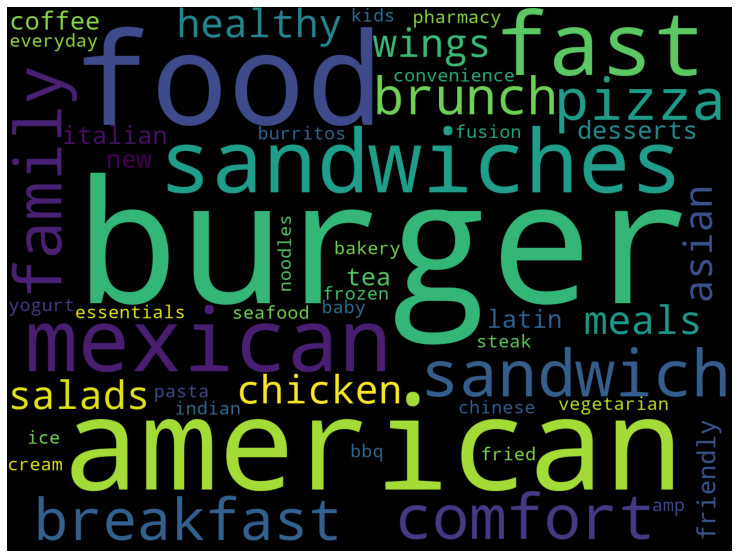

In [ ]:
#@title
cloud = WordCloud(width=1440, height= 1080,max_words= 1000).generate(' '.join(fifty_common_category_words))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off');

#### The most popular category and neighborhood

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


2457

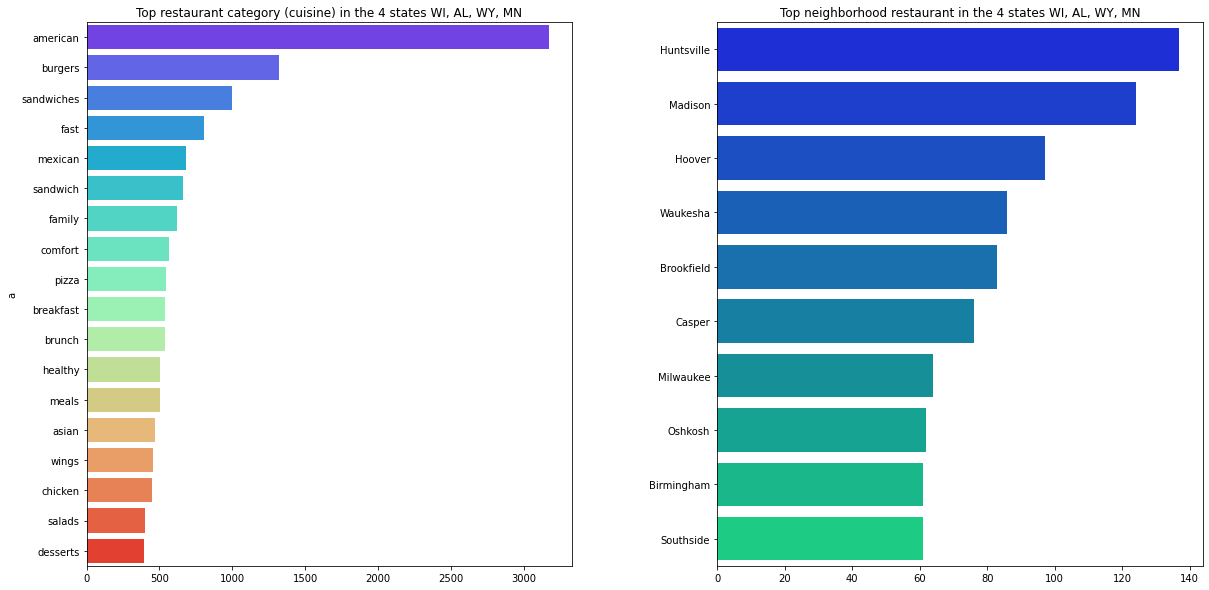

In [ ]:
#@title
f,ax = plt.subplots(1,2, figsize=(20,10))
ax1,ax2, = ax.flatten()
wordslist = Counter(category_words).most_common(20)
wordslist.remove(('food', 1447))
wordslist.remove(('and', 746))
d = wordslist
df = pd.DataFrame.from_records(list(dict(d).items()), columns=['a','category'])
df.reset_index(drop=True)
df
sns.barplot(df['category'], df['a'], palette = 'rainbow', ax =ax1)
ax1.set_xlabel('')
ax1.set_title('Top restaurant category (cuisine) in the 4 states WI, AL, WY, MN')

plot = res['Neighborhood'].value_counts()[:10].to_frame()

sns.barplot(plot['Neighborhood'], plot.index, palette = 'winter', ax =ax2)
ax2.set_xlabel('')
ax2.set_title('Top neighborhood restaurant in the 4 states WI, AL, WY, MN')
plt.subplots_adjust(wspace=0.3)
gc.collect()

In [ ]:
res['ratings_count'].describe()

count    2169.000000
mean       52.863071
std        42.944594
min        10.000000
25%        21.000000
50%        40.000000
75%        74.000000
max       200.000000
Name: ratings_count, dtype: float64

#### The most reviewed restaurants from the dataset. There are several restaurants that have around 200 reviews.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


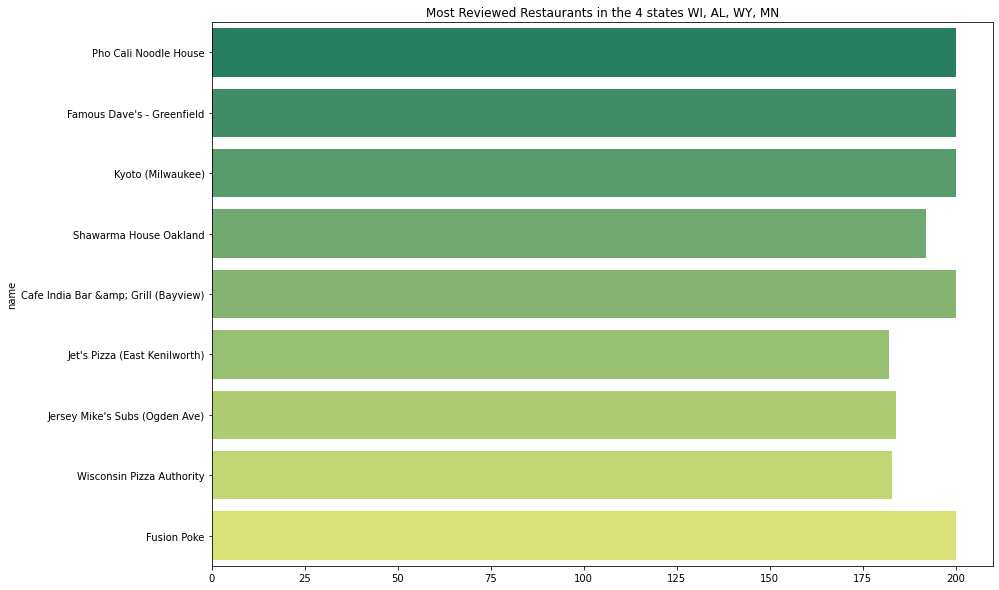

In [ ]:
#@title
plt.figure(figsize = (14,10))
sns.barplot(res[res['ratings_count'] >180][:10]['ratings_count'],res[res['ratings_count'] >180][:10]['name'],
           palette = 'summer')
plt.xlabel('')
plt.title('Most Reviewed Restaurants in the 4 states WI, AL, WY, MN');

#### The counties and states with the highest number of restaurants. Many of the restaurants from this dataset come from Wisconsin. These 2 graphs are consistent with each other since we determined from the graph on the left that Milwakee County, which is a part of Wisconsin, has the most restaurants.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


13031

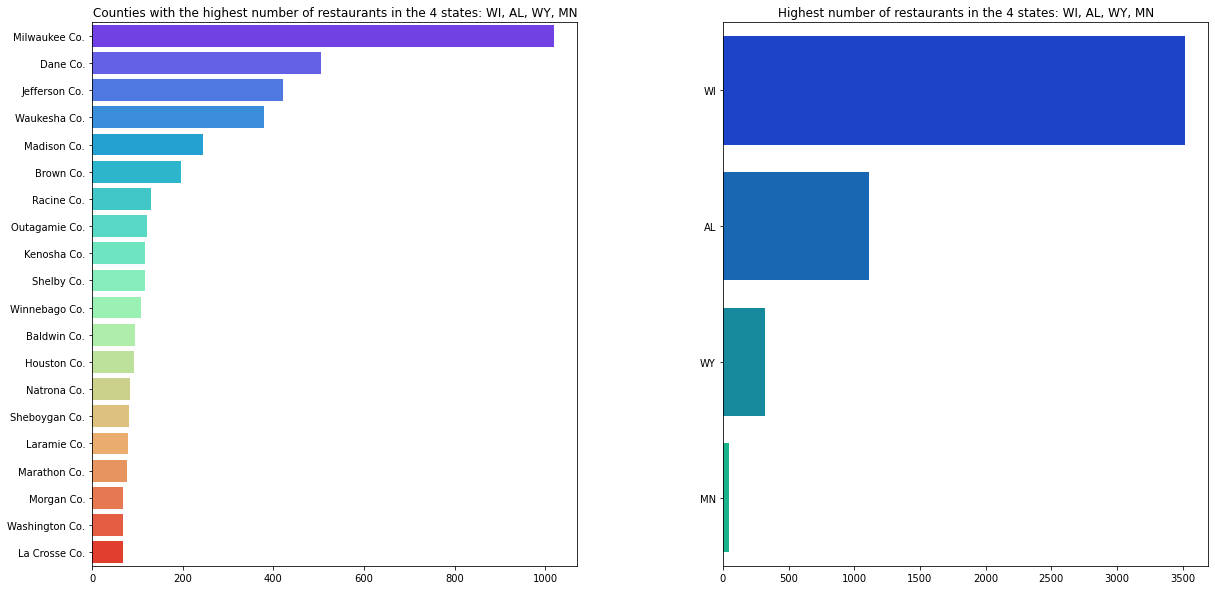

In [ ]:
#@title
f,ax = plt.subplots(1,2, figsize=(20,10))
ax1,ax2, = ax.flatten()
plot = res['County'].value_counts()[:20].to_frame()

sns.barplot(plot['County'], plot.index, palette = 'rainbow', ax =ax1)
ax1.set_xlabel('')
ax1.set_title('Counties with the highest number of restaurants in the 4 states: WI, AL, WY, MN')

plot = res['State'].value_counts()[:20].to_frame()
sns.barplot(plot['State'], plot.index, palette = 'winter', ax =ax2)
ax2.set_xlabel('')
ax2.set_title('Highest number of restaurants in the 4 states: WI, AL, WY, MN')
plt.subplots_adjust(wspace=0.3)
gc.collect()

In [ ]:
#@title
url_valid = "https://drive.google.com/file/d/1gDmSI0DlnI0R5JP4v65a11QqI1BDtVa3/view?usp=sharing"
url_valid = "https://drive.google.com/uc?id=" + url_valid.split("/")[-2]
res_valid = pd.read_csv(url_valid)

#### A heat map distribution of restaurant locations

In [ ]:
#@title
longs = list(res_valid['lng'])
lats = list(res_valid['lat'])
meanLong = statistics.mean(longs)
meanLat = statistics.mean(lats)
mapObj = folium.Map(location=[meanLat, meanLong], tiles="openstreetmap", zoom_start = 10)
mapObj
heatmap = HeatMap(list(zip(lats, longs, res_valid["score"])),
                   min_opacity=0.2,
                   max_val=res_valid["score"].max(),
                   radius=50, blur=50,
                   max_zoom=1)
heatmap.add_to(mapObj)
mapObj

In [ ]:
res['score'].describe()

count    2169.000000
mean        4.486860
std         0.319114
min         3.000000
25%         4.300000
50%         4.600000
75%         4.700000
max         5.000000
Name: score, dtype: float64

#### A sample of restaurants that have a perfect 5 star rating

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


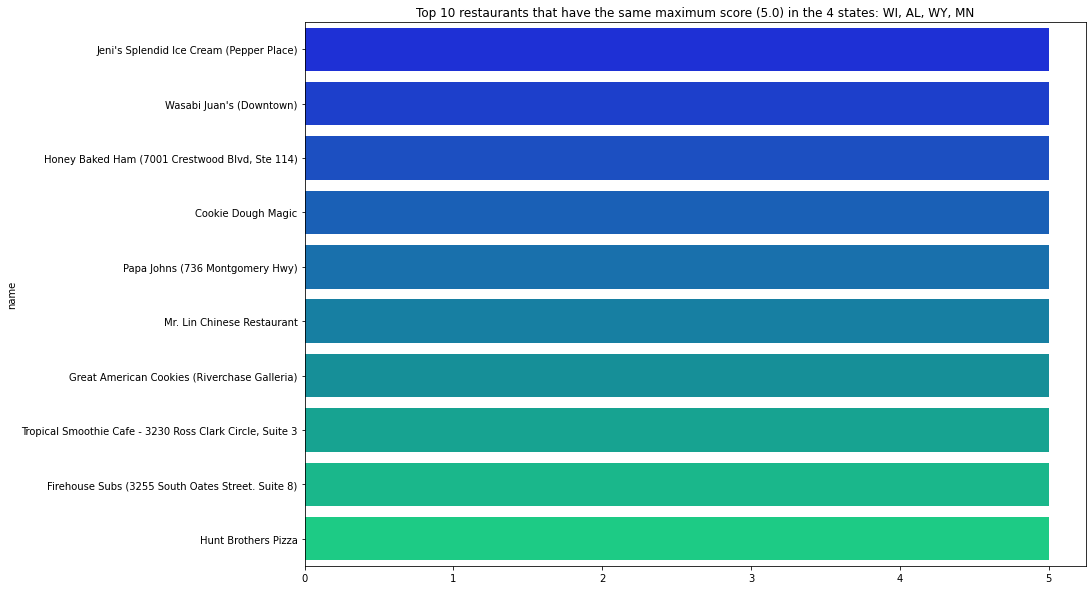

In [ ]:
#@title
plt.figure(figsize = (14,10))
sns.barplot(res[res['score'] == 5.0][:10]['score'],res[res['score'] == 5.0][:10]['name'],
           palette = 'winter')
plt.xlabel('')
plt.title('Top 10 restaurants that have the same maximum score (5.0) in the 4 states: WI, AL, WY, MN');

#### Restaurants that have the lowest ratings in the dataset

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


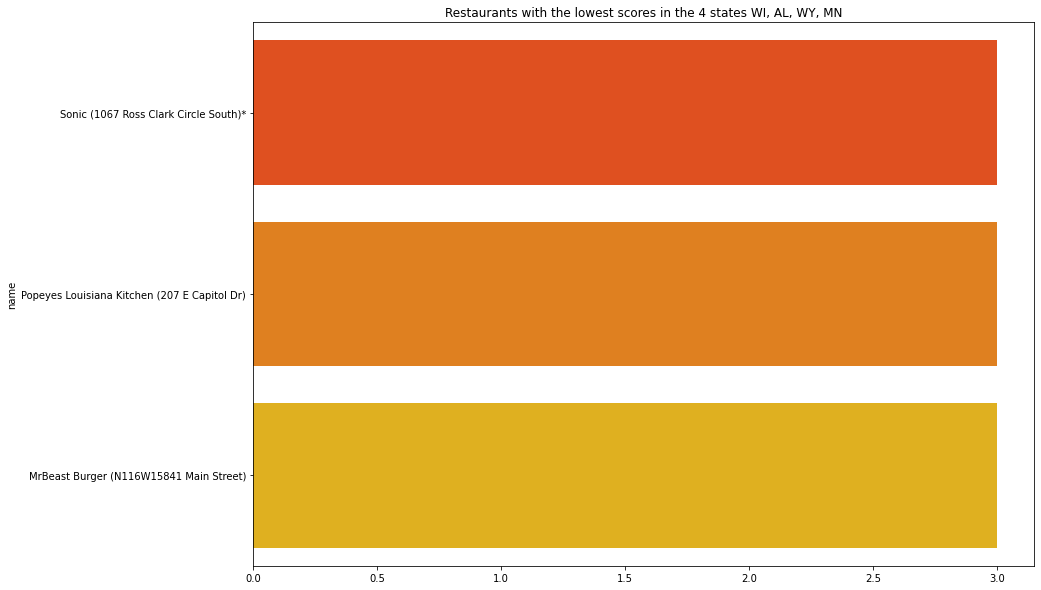

In [ ]:
#@title
plt.figure(figsize = (14,10))
sns.barplot(res[res['score'] == 3.0][:10]['score'],res[res['score'] == 3.0][:10]['name'],
           palette = 'autumn')
plt.xlabel('')
plt.title('Restaurants with the lowest scores in the 4 states WI, AL, WY, MN');

In [ ]:
#@title
def plot_compare_rating_counts(few_rating_counts_scores, many_rating_counts_scores, title=None):
    few_rating_counts_star_avg = few_rating_counts_scores.mean()
    few_rating_counts_star_count = few_rating_counts_scores.count()
    many_rating_counts_star_avg = many_rating_counts_scores.mean()
    many_rating_counts_star_count = many_rating_counts_scores.count()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar([0, 1], [few_rating_counts_star_avg, many_rating_counts_star_avg])
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Few number of customer ratings', 'Many number of customer ratings'])
    ax.set_ylim(0, 5)
    ax.text(0, few_rating_counts_star_avg, str(round(few_rating_counts_star_avg, 2)) + ' scores', ha='center', va='bottom')
    ax.text(1, many_rating_counts_star_avg, str(round(many_rating_counts_star_avg, 2)) + ' scores', ha='center', va='bottom')

    ax.text(0, few_rating_counts_star_avg*.5, str(few_rating_counts_star_count) + ' restaurants', ha='center', color='w')
    ax.text(1, many_rating_counts_star_avg*.5, str(many_rating_counts_star_count) + ' restaurants', ha='center', color='w')
    ax.set_ylabel('Average score ratings')
    ax.set_title(title)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis="y",direction="in")

#### Distribution of scores from the dataset. It is skewed in a way such that most restaurants are highly rated, but some are much more lowly rated

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


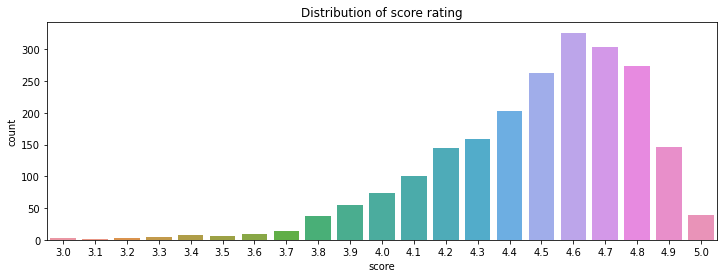

In [ ]:
#@title
plt.figure(figsize=(12,4))
ax = sns.countplot(res['score'])
plt.title('Distribution of score rating');

In [ ]:
#@title
res['highly_rated'] = (res['score'] > 4.9)
res['many_rating_counts'] = res['ratings_count'] > 180

#### Checking to see if restaurants with few ratings are scored differently from restaurants with many ratings. There is no evidence of a difference in ratings as the scores are similar to each other.

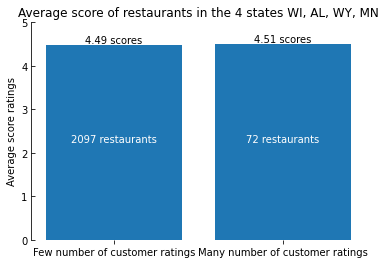

In [ ]:
#@title
plot_compare_rating_counts(res[res['many_rating_counts']==False]['score'], res[res['many_rating_counts']]['score'],'Average score of restaurants in the 4 states WI, AL, WY, MN')

#### Checking for a difference in ratings from a smaller subset of restaurants (American and Asian). There is still no evidence of a difference in ratings.

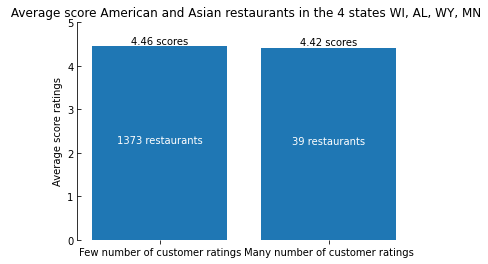

In [ ]:
#@title
res['category'] = res['category'].fillna("")
american_type = res['category'].apply(lambda a: False if (a is None or a.find('American') == -1 ) else True)
american_df = res[american_type]

res['category'] = res['category'].fillna("")
asian_type = res['category'].apply(lambda a: False if (a is None or a.find('Asian') == -1 ) else True)
asian_df = res[asian_type]

american_asian_df = pd.concat([american_df,asian_df]).drop_duplicates().reset_index(drop=True)
plot_compare_rating_counts(american_asian_df[american_asian_df['many_rating_counts']==False]['score'], american_asian_df[american_asian_df['many_rating_counts']]['score'],' Average score American and Asian restaurants in the 4 states WI, AL, WY, MN')


#### Checking for a difference in ratings looking at just American restaurants. Based on the plot, there is some evidence of a very small difference in ratings between restaurants with fewer reviews and restaurants with many reviews.

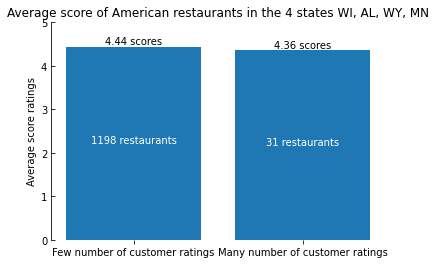

In [ ]:
#@title
plot_compare_rating_counts(american_df[american_df['many_rating_counts']==False]['score'], american_df[american_df['many_rating_counts']]['score'],'Average score of American restaurants in the 4 states WI, AL, WY, MN')

#### Overall, restaurants with few reviews have similar scores/ratings to restaurants with many reviews.

### 5. Machine Learning

#### Goal: To predict the review scores of restaurants from the dataset that do not have any reviews to begin with.

In [ ]:
#@title
url = "https://drive.google.com/file/d/11qyN2BV_7JLrhx5ax40p1k_k6e5JrZME/view?usp=sharing"
url = "https://drive.google.com/uc?id=" + url.split("/")[-2]
df_res = pd.read_csv(url)
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

In [ ]:
#@title
df_res = df_res.drop(["price_range", "full_address"], axis=1)
df_res["ratings"] = df_res["ratings"].fillna(0)
df_res["category"] = df_res["category"].values.astype(str)
df_res_scores_valid = df_res[~df_res['score'].isnull()]
df_res_scores_not_valid = df_res[df_res['score'].isnull()]

#### Here, we split the data into two sets: one of which has rated restaurants, and another with unrated restaurants.

In [ ]:
df_res_scores_valid.head()

,id,position,name,score,ratings,category,zip_code,lat,lng,County,Address,Neighborhood,State,price
4,5,162,Nelson Brothers Cafe (17th St N),4.7,22.0,"Breakfast and Brunch, Burgers, Sandwiches",35203,33.514730,-86.811700,Jefferson Co.,"314 17th St N, Birmingham, AL 35203, United St...",Northside,AL,4.53
6,7,27,Jinsei Sushi,4.7,63.0,"Sushi, Asian, Japanese",35209,33.480440,-86.790440,Jefferson Co.,"2850 19th St S, Homewood, AL 35209, United States",Homewood,AL,13.45
13,14,51,Panera (521 Fieldstown Road),4.6,44.0,"Breakfast and Brunch, salad, Sandwich, Family ...",35071,33.651407,-86.819247,Jefferson Co.,"2520 Caufield Dr, Gardendale, AL 35071, United...",Gardendale,AL,9.50
15,16,88,Jeni's Splendid Ice Cream (Pepper Place),5.0,20.0,"Ice Cream &amp; Frozen Yogurt, Comfort Food, D...",35233,33.516600,-86.789950,Jefferson Co.,"2900 3rd Ave S, Birmingham, AL 35233, United S...",Southside,AL,13.02
18,19,30,Falafel Cafe,4.9,48.0,"Middle Eastern, Mediterranean, Vegetarian, Gre...",35233,33.508353,-86.803170,Jefferson Co.,"401 19th St S, Birmingham, AL 35233, United St...",Southside,AL,4.80


In [ ]:
df_res_scores_not_valid.head()

,id,position,name,score,ratings,category,zip_code,lat,lng,County,Address,Neighborhood,State,price
0,1,19,PJ Fresh (224 Daniel Payne Drive),NaN,0.0,"Burgers, American, Sandwiches",35207,33.562365,-86.830703,Jefferson Co.,"224 Daniel Payne Dr, Birmingham, AL 35207, Uni...",North Birmingham,AL,5.66
1,2,9,J' ti`'z Smoothie-N-Coffee Bar,NaN,0.0,"Coffee and Tea, Breakfast and Brunch, Bubble Tea",35217,33.583640,-86.773330,Jefferson Co.,"1521 Pinson Valley Pkwy, Birmingham, AL 35217,...",Birmingham,AL,5.51
2,3,6,Philly Fresh Cheesesteaks (541-B Graymont Ave),NaN,0.0,"American, Cheesesteak, Sandwiches, Alcohol",35204,33.509800,-86.854640,Jefferson Co.,"1101 Graymont Ave W, Birmingham, AL 35204, Uni...",Five Points West,AL,10.76
3,4,17,Papa Murphy's (1580 Montgomery Highway),NaN,0.0,Pizza,35226,33.404439,-86.806614,Jefferson Co.,"1580 Montgomery Hwy, Hoover, AL 35226, United ...",Hoover,AL,10.53
5,6,75,Ocean Restaurant,NaN,0.0,"Seafood, Sushi, Steak",35205,33.498630,-86.795740,Jefferson Co.,"1214 20th St S, Birmingham, AL 35205, United S...",Southside,AL,28.75


In [ ]:
#@title
df_res_scores_valid = df_res_scores_valid.dropna(subset=["price"])
df_res_scores_not_valid = df_res_scores_not_valid.dropna(subset=["price"])

#### We split the valid scores dataset into a training and test set to fit and assess various models before deciding on a best model.

In [ ]:
df_train = df_res_scores_valid.sample(frac=0.8)
df_test = df_res_scores_valid.drop(df_train.index)
X_train = df_train.drop("score", axis=1)
y_train = df_train["score"]
X_test = df_test.drop("score", axis=1)
y_test = df_test["score"]

#### After analysis of various models, we decided to use a KNearestNeighbors model with the predictor variables state, county, average price, and category, using a k-value of 25 based on the resulting mean squared error scores.

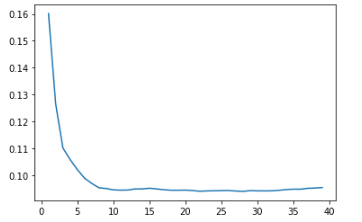

In [ ]:
#@title
ct = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), ["State", "County"]),
    (StandardScaler(), ["price"]),
    (TfidfVectorizer(max_features=100), "category")
)
pipeline = make_pipeline(
    ct,
    KNeighborsRegressor(n_neighbors=25)
)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['State', 'County']),
                                                 ('standardscaler',
                                                  StandardScaler(), ['price']),
                                                 ('tfidfvectorizer',
                                                  TfidfVectorizer(max_features=100),
                                                  'category')])),
                ('kneighborsregressor', KNeighborsRegressor(n_neighbors=25))])

Comparing the predictions from the test data to the actual scores, we can see that this model does a good job at making predictions, with the average prediction being very close to the recorded scores.

In [ ]:
y_test_ = pipeline.predict(X_test)
(y_test_ - y_test).mean()

-0.004378752886836042

In [ ]:
#@title
to_predict = df_res_scores_not_valid.drop("score", axis=1)
prediction = pipeline.predict(to_predict)
df_res_scores_not_valid["score"] = prediction
df_res_scores_not_valid.head()

,id,position,name,score,ratings,category,zip_code,lat,lng,County,Address,Neighborhood,State,price
0,1,19,PJ Fresh (224 Daniel Payne Drive),4.444,0.0,"Burgers, American, Sandwiches",35207,33.562365,-86.830703,Jefferson Co.,"224 Daniel Payne Dr, Birmingham, AL 35207, Uni...",North Birmingham,AL,5.66
1,2,9,J' ti`'z Smoothie-N-Coffee Bar,4.452,0.0,"Coffee and Tea, Breakfast and Brunch, Bubble Tea",35217,33.583640,-86.773330,Jefferson Co.,"1521 Pinson Valley Pkwy, Birmingham, AL 35217,...",Birmingham,AL,5.51
2,3,6,Philly Fresh Cheesesteaks (541-B Graymont Ave),4.492,0.0,"American, Cheesesteak, Sandwiches, Alcohol",35204,33.509800,-86.854640,Jefferson Co.,"1101 Graymont Ave W, Birmingham, AL 35204, Uni...",Five Points West,AL,10.76
3,4,17,Papa Murphy's (1580 Montgomery Highway),4.444,0.0,Pizza,35226,33.404439,-86.806614,Jefferson Co.,"1580 Montgomery Hwy, Hoover, AL 35226, United ...",Hoover,AL,10.53
5,6,75,Ocean Restaurant,4.452,0.0,"Seafood, Sushi, Steak",35205,33.498630,-86.795740,Jefferson Co.,"1214 20th St S, Birmingham, AL 35205, United S...",Southside,AL,28.75


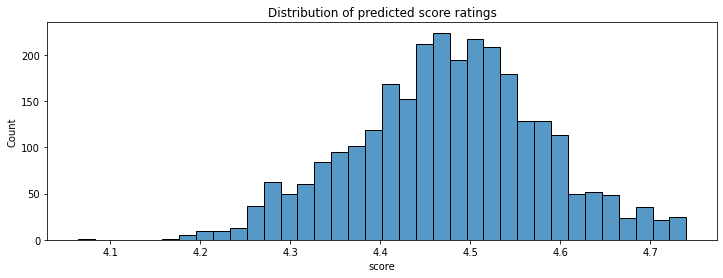

In [ ]:
#@title
plt.figure(figsize=(12,4))
ax = sns.histplot(df_res_scores_not_valid['score'])
plt.title('Distribution of predicted score ratings');

This histogram, unlike the histogram from the data with recorded scores, shows a normal distribution, which is likely because the model is very unlikely to predict outliers since it is being trained on a very large dataset. However, we can see that the average score from this distribution is between 4.4 and 4.5, which is what we observed in the data with known restaurant ratings.